In [1]:
if 'google.colab' in str(get_ipython()):
    import sys
    from google.colab import drive, output
    drive.mount('/content/drive')

    !pip install umap-learn
    !pip install umap-learn[plot]
    !pip install holoviews

    !pip install joypy

    output.clear()
    print("Running on colab")
    %load_ext autoreload
    %autoreload 1
    %cd '/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project'
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Dataloader')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Models')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Modules')
elif "zmqshell" in str(get_ipython()):
    print("Running on MIRP")
    root = "/home/mirp_ai/Documents/Daniel_Nieto/PhD/AutoEncoders_Ecoacoustics"
    root_path = "/media/mirp_ai/Seagate Desktop Drive/Datos Rey Zamuro/Ultrasonido"
else:
    import pathlib
    temp = pathlib.PosixPath
    pathlib.PosixPath = pathlib.WindowsPath
    print("Running local")

Running on MIRP


In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from six.moves import xrange
import datetime
import gc
import pandas as pd
import joypy

from scipy import signal
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler as Normalizer

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torchaudio.transforms as audio_transform


#from ResidualStack import ResidualStack
#from Residual import Residual

from Jaguas_DataLoader_rainless import SoundscapeData
from Models import ConvAE as AE
from AE_training_functions import TestModel, TrainModel
from AE_Clustering import AE_Clustering 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = xm.xla_device()

from datetime import timedelta
import wandb
from wandb import AlertLevel

!pip install umap-learn
!pip install umap-learn[plot]
import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import seaborn as sns
import pickle as pkl

import random
def _set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).
 
    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
_set_seed(1024)

gc.collect()

33313

In [3]:
model_type = "AE"
identifier = "batch_size_14_num_hiddens_64_"
day = 4
hour = 9
date_format = f"day_{day}_hour_{hour}"

# model_name = f"{root}/Zamuro/temporal_zamuro/models/model_{model_type}_{identifier}_{date_format}_final.pth"
# config = torch.load(f'{root}/Zamuro/temporal_zamuro/configs/config_{model_type}_{identifier}_{date_format}.pth', map_location=torch.device('cpu'))
# model = AE(num_hiddens=config["num_hiddens"]).to(device)
# model.load_state_dict(torch.load(f'{model_name}', map_location=torch.device('cpu')))

# y = torch.load(f"temporal_zamuro/Features/{folder}/AE_labels_{date_format}_No_rain_Audios_Jaguas.pth",  map_location=torch.device('cpu'))
# X = torch.load(f"{root}/Zamuro/temporal_zamuro/Features/AE_features_Zamuro.pth",  map_location=torch.device('cpu'))
X_ae_norm = np.load(f"temporal_zamuro/Features/X_ae_norm.pth.npy")
y_ae = np.load(f"temporal_zamuro/Features/y_ae.pth.npy")
audios = pd.read_csv(f"Complementary_Files/zamuro_audios.csv", index_col=0)
# y_path = torch.load(f"{root}/Zamuro/temporal_zamuro/Features/AE_test_path_samples_Zamuro.pth",  map_location=torch.device('cpu'))
# path_flat = [item for sublist in y_path for item in sublist]
# path_flat = np.asarray(path_flat)
# print(X.shape)

# scaler = StandardScaler().fit(X)
# X_scaled = scaler.transform(X)
# Normalizer_ = Normalizer().fit(X)
# X_norm = Normalizer_.transform(X)
# PCA_ = PCA(n_components=60).fit(X_norm)
# X_PCA = PCA_.transform(X_norm)
# # X_TSNE = TSNE(n_components=60, learning_rate="auto", init='random', random_state=0).fit_transform(X_PCA)
# reducer = umap.UMAP(min_dist=0.9, n_components=60)
# X_UMAP = reducer.fit_transform(X_norm)
# X_batch = np.reshape(X_UMAP, (X_UMAP.shape[0]//5,5,X_UMAP.shape[1]))
# # X_UMAP_Norm = Normalizer().fit_transform(X_UMAP)

In [4]:
from datetime import datetime, time
def obtener_hora(row):
    hora_str = row['name_FI'].split('_')[1]  # Obtener la parte de la hora
    hora = time(hour=int(hora_str[:2]), minute=int(hora_str[2:4]), second=int(hora_str[4:6]))
    return hora

# Aplicar la función a cada fila y crear una nueva columna 'hora'
audios['hora'] = audios.apply(obtener_hora, axis=1)


In [5]:
from sklearn.preprocessing import LabelEncoder
y_hora = []
y_site = []
for i in range(len(y_ae)):
    y_hora.append(int(y_ae[i].split("_")[2][0:2]))
    y_site.append(y_ae[i].split("_")[0])
    
encoder = LabelEncoder()
y_site = encoder.fit_transform(y_site)

In [ ]:
y_n = y_hora
X_ = [X_scaled, X_norm, X_PCA, X_TSNE, X_UMAP]
Feats = ["Scaled", "Norm", f"PCA{n_components}", "TSNE", "UMAP"]
for enum, x in enumerate(X_):
    sns.jointplot(x=X_[enum][:,0], y= X_[enum][:,1], hue=y_n, joint_kws={'alpha': 0.03}) 
#     plt.savefig(f"Projection_{model}_{Feats[enum]}_{metadata}_alpha_03")

In [ ]:
tasa_submuestreo = 1

# Obtener el número de muestras a submuestrear
num_muestras_submuestreadas = int(len(X_ae_norm) * tasa_submuestreo)

# Generar índices aleatorios sin reemplazo
indices_submuestreo = np.random.choice(len(X_ae_norm), num_muestras_submuestreadas, replace=False)

X_norm = X_ae_norm[indices_submuestreo]
y_n = [y_hora[i] for i in indices_submuestreo]

In [ ]:
reducer = umap.UMAP(min_dist=0.2, n_components=2)
X_UMAP = reducer.fit_transform(X_norm)

In [ ]:
a= np.arange(X_UMAP.shape[0])
a = np.random.choice(a, size=len(X_UMAP)//2)
new_embedding = X_UMAP[a]
y_n = np.array(y_n)
y_n2 = y_n[a]

plt.scatter(
    new_embedding[:, 0],
    new_embedding[:, 1], c=y_n2, alpha=0.5, s=0.1)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of Zmuro dataset', fontsize=14);

In [6]:
def projector(data, y=None, method="PCA", n_components=2, random_state=0, **kwargs):
    
    if method == "PCA":
        X = PCA(n_components=n_components, random_state=0).fit_transform(data)
    elif method == "ICA":
        X = FastICA(n_components=n_components,
                    random_state=0).fit_transform(data)
    elif method == "tSNE":
        X = TSNE(n_components=n_components, learning_rate=kwargs["learning_rate"],
                 init=kwargs["init"], random_state=random_state,
                 n_jobs=kwargs["n_jobs"]).fit_transform(X_PCA)
        
    elif method == "UMAP":
        reducer = umap.UMAP(n_components=n_components, min_dist=kwargs["min_dist"],
                            metric=kwargs["metric"], n_neighbors=kwargs["n_neighbors"],
                            random_state=random_state, n_jobs=kwargs["n_jobs"])
        X = reducer.fit_transform(data)
    return X

In [ ]:
a=projector(X_ae_norm[:100000], method="UMAP", min_dist=0.5, n_neighbors=60, metric="euclidean")
plt.scatter(a[:,0], a[:,1],alpha=0.5, s=0.1)

iterating with: 
 metric: correlation 
 min_dist: 0.1, 
 n_neighbors: 15


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


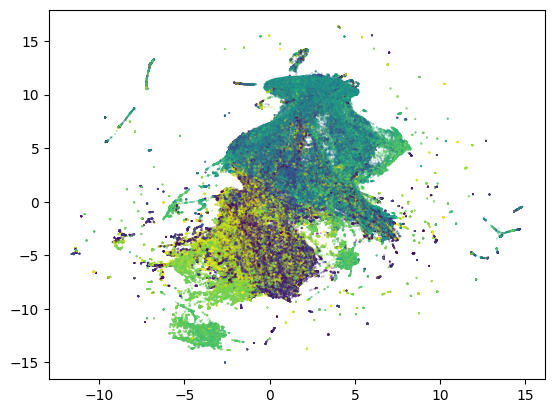

iterating with: 
 metric: correlation 
 min_dist: 0.1, 
 n_neighbors: 60


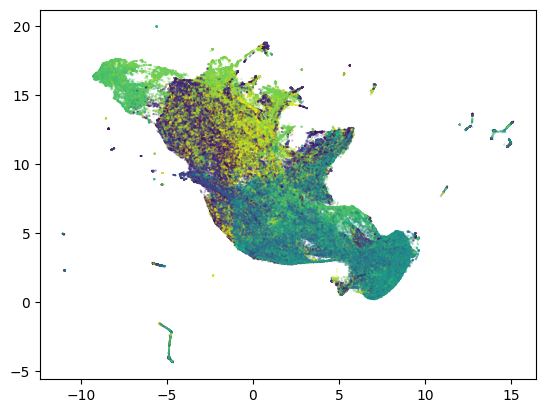

iterating with: 
 metric: correlation 
 min_dist: 0.1, 
 n_neighbors: 180


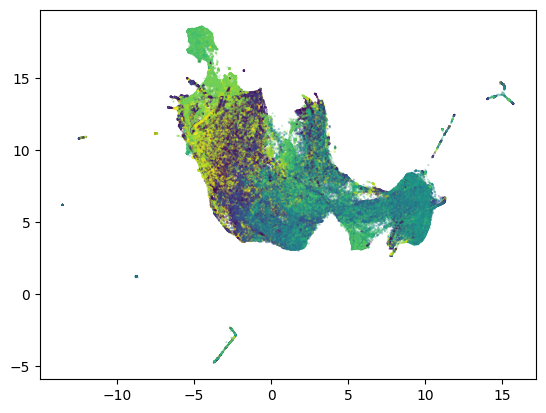

iterating with: 
 metric: correlation 
 min_dist: 0.1, 
 n_neighbors: 512


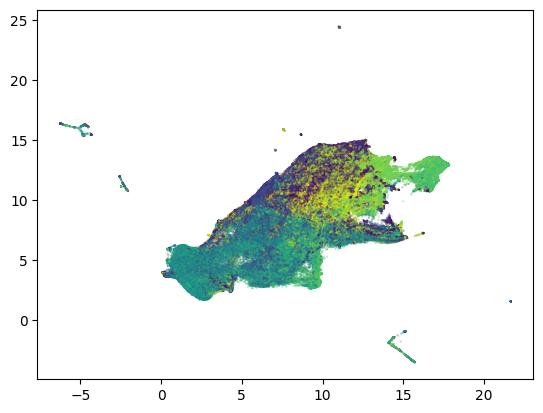

iterating with: 
 metric: correlation 
 min_dist: 0.5, 
 n_neighbors: 15


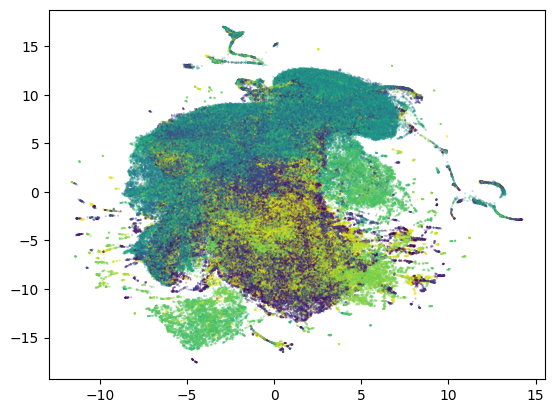

iterating with: 
 metric: correlation 
 min_dist: 0.5, 
 n_neighbors: 60


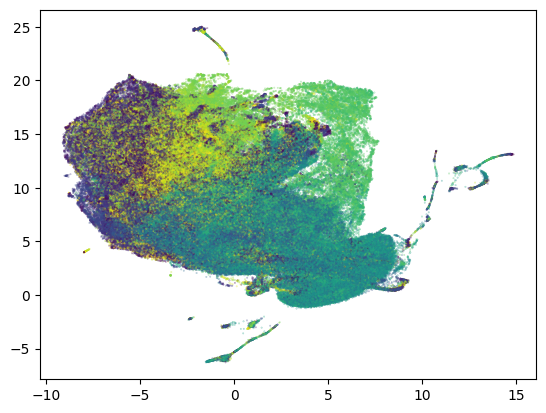

iterating with: 
 metric: correlation 
 min_dist: 0.5, 
 n_neighbors: 180


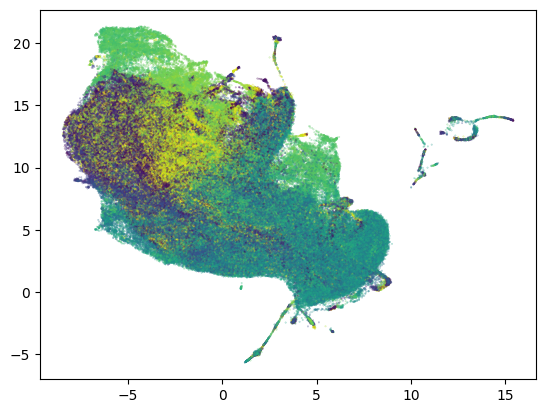

iterating with: 
 metric: correlation 
 min_dist: 0.5, 
 n_neighbors: 512


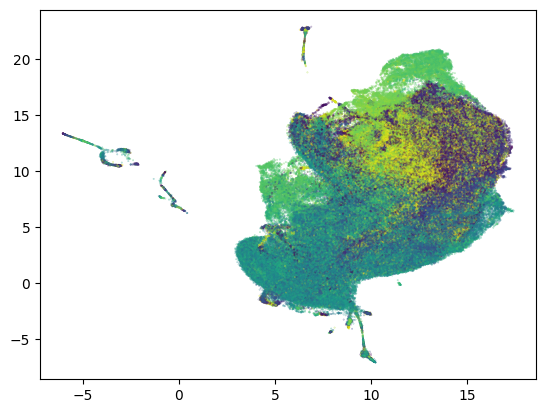

iterating with: 
 metric: correlation 
 min_dist: 1, 
 n_neighbors: 15


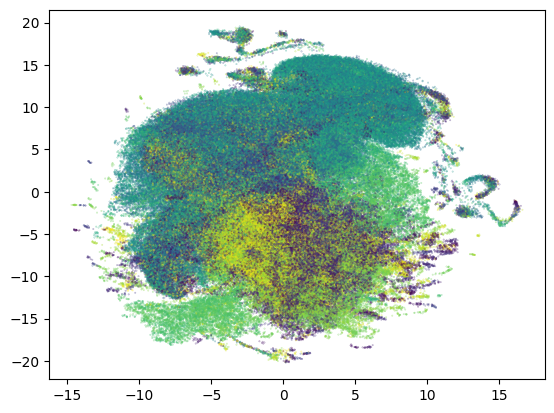

iterating with: 
 metric: correlation 
 min_dist: 1, 
 n_neighbors: 60


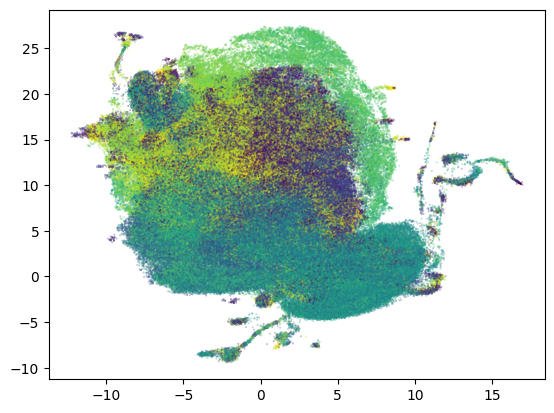

iterating with: 
 metric: correlation 
 min_dist: 1, 
 n_neighbors: 180


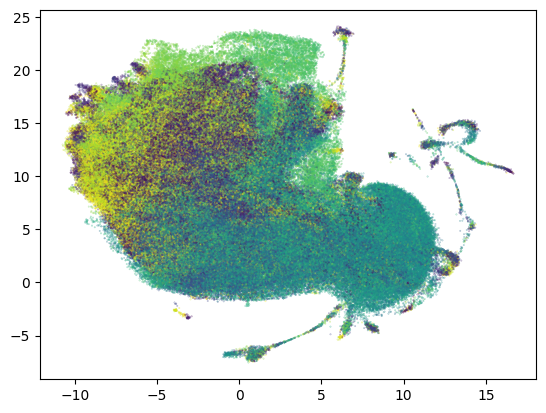

iterating with: 
 metric: correlation 
 min_dist: 1, 
 n_neighbors: 512


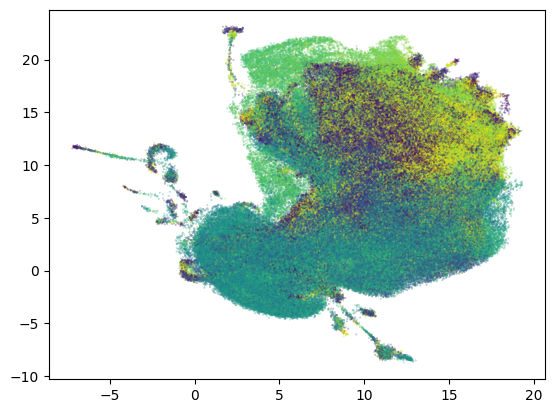

In [8]:
metrics = ["correlation"]#["euclidean", "minkowski", "mahalanobis", "correlation"]
min_dists = [0.1, 0.5, 1]
n_neighbors = [15, 60, 180, 512]

for metric in metrics:
    for min_dist in min_dists:
        for n_neighbor in n_neighbors:
            print(f"iterating with: \n metric: {metric} \n min_dist: {min_dist}, \n n_neighbors: {n_neighbor}")
            X_projected = projector(X_ae_norm, method="UMAP", 
                                    min_dist=min_dist,
                                    n_neighbors=n_neighbor,
                                    metric=metric, n_jobs=-1)
            plt.scatter(X_projected[:,0], X_projected[:,1],alpha=0.5, s=0.1, c=y_hora)
            plt.savefig(f"temporal_zamuro/zamuro_projections/hour/UMAP_metric-{metric}_mindist-{min_dist}_nneighbors-{n_neighbor}.pdf")
            plt.show()
       

In [ ]:
metrics = ["euclidean", "minkowski"]#, "mahalanobis", "correlation"]
for metric in metrics:
    for min_dist in min_dists:
        for n_neighbor in n_neighbors:
            print(f"iterating with: \n metric: {metric} \n min_dist: {min_dist}, \n n_neighbors: {n_neighbor}")
            X_projected = projector(X_ae_norm, method="UMAP",
                                    min_dist=min_dist,
                                    n_neighbors=n_neighbor,
                                    metric=metric, n_jobs=-1)
            plt.scatter(X_projected[:,0], X_projected[:,1],alpha=0.5, s=0.1, c=y_site)
            plt.savefig(f"temporal_zamuro/zamuro_projections/site/UMAP_metric-{metric}_mindist-{min_dist}_nneighbors-{n_neighbor}.pdf")
            plt.show()

iterating with: 
 metric: euclidean 
 min_dist: 0.1, 
 n_neighbors: 15
